# Introducción

El servicio de venta de autos usados Rusty Bargain necesita desarrollara una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Se tiene acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Se tiene que desarrollar un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

# Inicialización

In [2]:
import pandas as pd
import numpy as np
from re import sub
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline as pl

from xgboost import XGBRegressor
from catboost import Pool, CatBoostRegressor
import lightgbm as lgb

# Preparación de datos

In [3]:
# Cargamos la información en un data frame
try:
    cars_df = pd.read_csv('/datasets/car_data.csv')
except:
    cars_df = pd.read_csv('car_data.csv')

In [4]:
cars_df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [11]:
# Visualizamos un resumen de la información
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

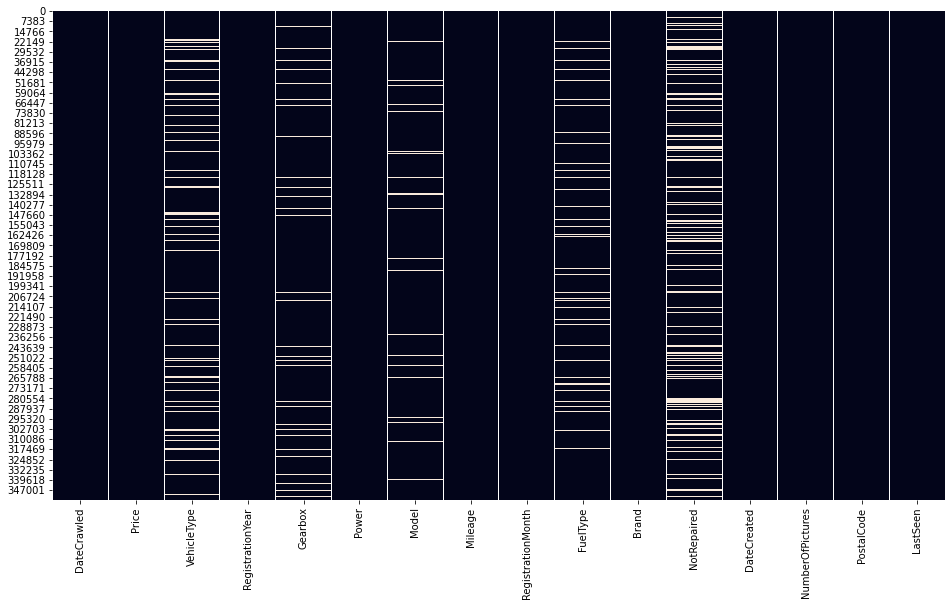

In [12]:
# Visulizamos los valores ausentes
plt.figure(figsize = (16,9))
sns.heatmap(cars_df.isnull(), cbar=False)
plt.show()

**Conclusiones:**

Existen varios valores ausentes y tipos de datos que no corresponden a la característica, estos inconvenientes serán tratados de acuerdo a las necesidades para crear un modelo.

# Preparación de datos

## Imutación de valores nulos

In [13]:
# Convertimos las columnas en snake case

def snake_case(s):
    return '_'.join(
        sub('([A-Z][a-z]+)', r' \1',
        sub('([A-Z]+)', r' \1',
        s.replace('-', ' '))).split()).lower()
cars_df.columns = [snake_case(column) for column in cars_df.columns]
cars_df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

In [14]:
# Seleccionamos las características que influyen sobre el precio de un automovil, las demás serán descartadas.

selected = ['price','vehicle_type', 'registration_year','gearbox', 'power', 'model', 'mileage', 'fuel_type', 'brand','not_repaired']
cars_df = cars_df[selected]
cars_df.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<AxesSubplot:>

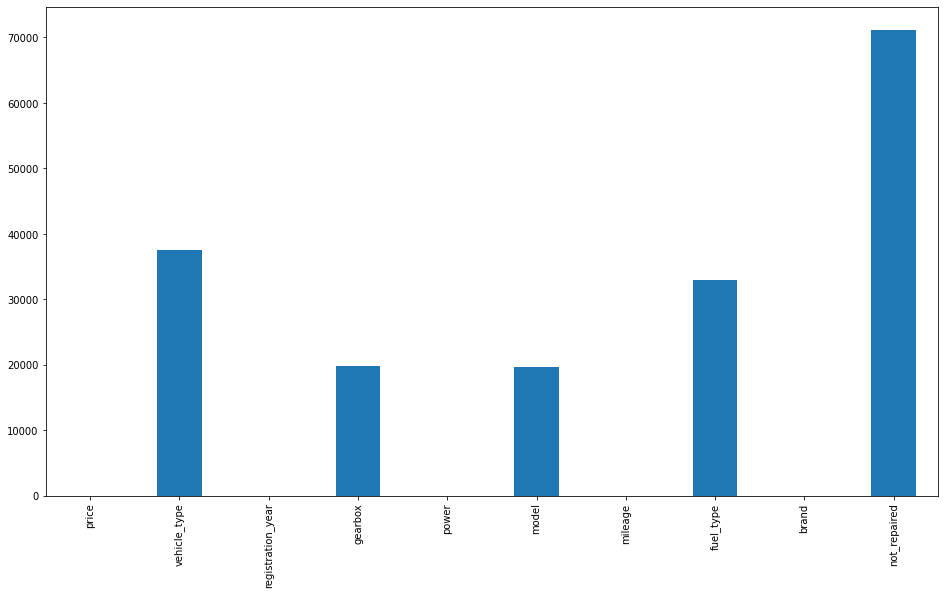

In [15]:
# Visualizamos la cantidad de valores nulos
cars_df.isnull().sum().plot(kind= 'bar', figsize= (16,9))

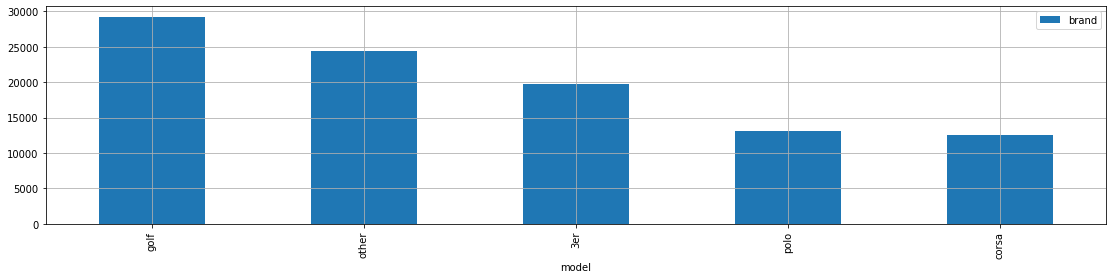

In [16]:
#Visualizamos la distribución para la característica modelo
(cars_df.pivot_table(index= 'model',values ='brand',aggfunc= 'count')
       .sort_values(by= 'brand', ascending= False)
       .head()
       .plot(kind= 'bar', grid= True, figsize= (19,4)))
plt.show()

**Ya que el segundo valor mas frecuente para la característica modelo es "other" se imputará los valores ausentes con este valor.**

In [17]:
# Imputamos con el valor "other" al conjunto de datos para la característica modelo.
cars_df['model'].fillna('other', inplace= True)

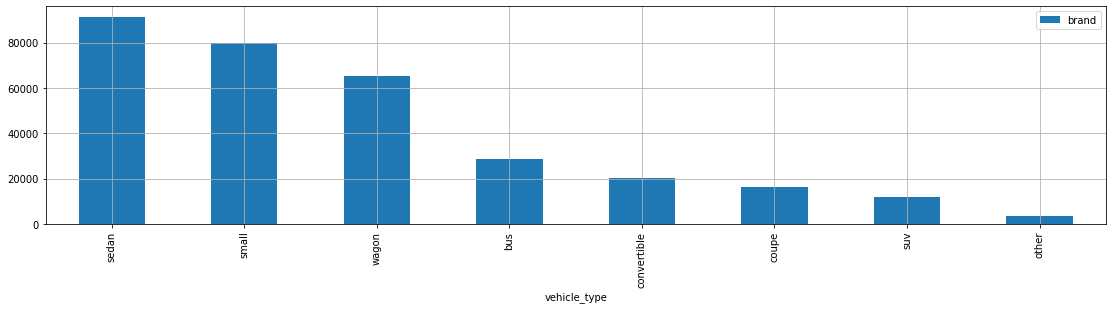

In [18]:
#Visualizamos la distribución para la característica 'vehicle_type'
(cars_df.pivot_table(index= 'vehicle_type',values ='brand',aggfunc= 'count')
       .sort_values(by= 'brand', ascending= False)
       .head(10)
       .plot(kind= 'bar', grid= True, figsize= (19,4)))
plt.show()

**Para el caso de la característica 'vehicle type' crearemos una categoría 'unknown'.**

In [19]:
cars_df['vehicle_type'].fillna('unknown', inplace= True)

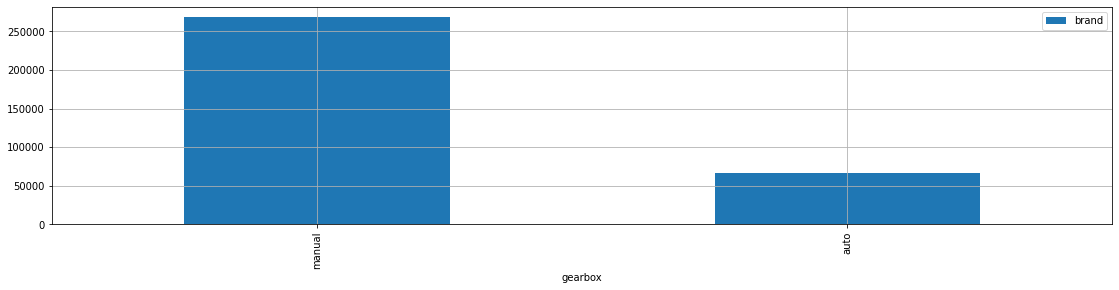

In [20]:
#Visualizamos la distribución para la característica 'gearbox'
(cars_df.pivot_table(index= 'gearbox',values ='brand',aggfunc= 'count')
       .sort_values(by= 'brand', ascending= False)
       .head(10)
       .plot(kind= 'bar', grid= True, figsize= (19,4)))
plt.show()

**Para el caso de la característica 'gearbox' crearemos una categoría 'unknown'.**


In [21]:
cars_df['gearbox'].fillna('unknown', inplace= True)

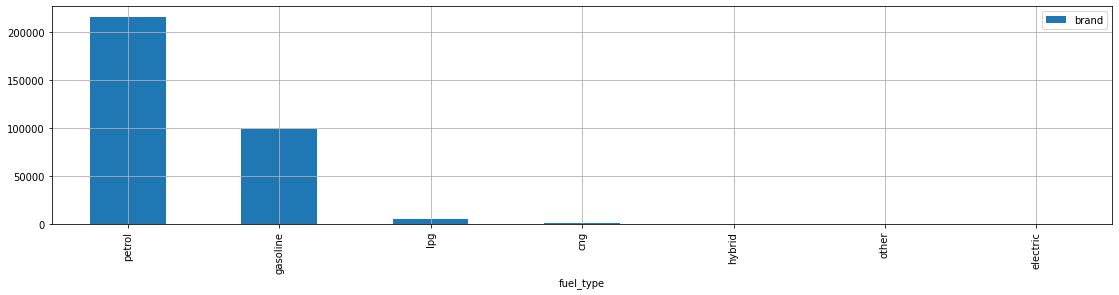

In [22]:
#Visualizamos la distribución para la característica 'fuel_type'
(cars_df.pivot_table(index= 'fuel_type',values ='brand',aggfunc= 'count')
       .sort_values(by= 'brand', ascending= False)
       .head(10)
       .plot(kind= 'bar', grid= True, figsize= (19,4)))
plt.show()

**Para el caso de la característica 'fuel_type' crearemos una categoría 'unknown'.**

In [23]:
cars_df['fuel_type'].fillna('unknown', inplace= True)

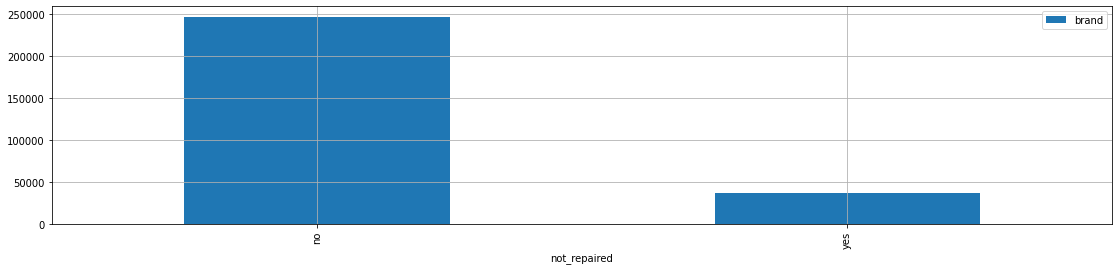

In [24]:
#Visualizamos la distribución para la característica 'fuel_type'
(cars_df.pivot_table(index= 'not_repaired',values ='brand',aggfunc= 'count')
       .sort_values(by= 'brand', ascending= False)
       .head(10)
       .plot(kind= 'bar', grid= True, figsize= (19,4)))
plt.show()

**Para el caso de la característica 'not_repaired' crearemos la categoría 'unknown'.**

In [25]:
cars_df['not_repaired'].fillna('unknown', inplace= True)

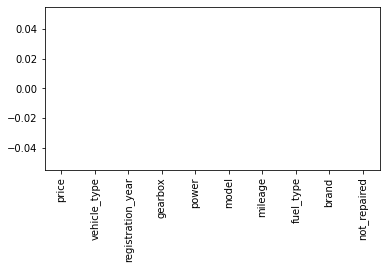

In [26]:
# Visualizamos nuevamente la cantidad de volores nulos en nuestro conjunto de datos.
cars_df.isnull().sum().plot(kind= 'bar', figsize= (6,3))
plt.show()

## Verificación de valores atípicos.

<AxesSubplot:>

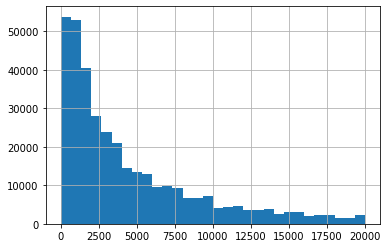

In [27]:
# Validamos la distribución de la característica 'price'.
cars_df['price'].hist(bins= 30)


<AxesSubplot:>

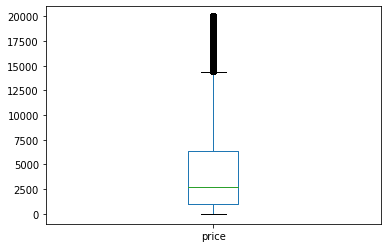

In [28]:
cars_df['price'].plot(kind= 'box')

In [29]:
# Número de valores '0' para price.
print(f'porcentaje de valores "0": {round(cars_df[cars_df["price"] == 0].shape[0]/cars_df.shape[0]*100,2)} %')

porcentaje de valores "0": 3.04 %


**Conclusiones:**

Existen observaciones con valor 0 para la característica 'price', pero estas solo representan el 3.04 %, por lo tanto serán eliminadas del conjunto de datos.

In [30]:
# Eliminamos los valores '0' del cojunto de datos.
cars_df = cars_df[cars_df['price'] > 0]

In [31]:
cars_df[cars_df['price'] == 0].shape[0]

0

**Validamos valores atípicos para la característica 'vehicle_type'.**

<AxesSubplot:>

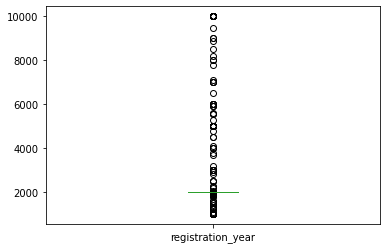

In [32]:
#Validamos valores atípicos para la característica 'vehicle_type'.
cars_df['registration_year'].plot(kind= 'box')

In [33]:
# Verificamos cunatos valores hay con un 'registration_year' mayor que 1970 y menor a 2023.
reg_year = cars_df[(cars_df['registration_year']>1970) & (cars_df['registration_year'] < 2023)]['registration_year'].shape[0]

In [34]:
# Número de valores '0' para price.
print(f'porcentaje de valores menor a 2023 y mayor a 1970: {round(100-(reg_year/cars_df.shape[0]*100),2)} %')

porcentaje de valores menor a 2023 y mayor a 1970: 0.45 %


**Conclusiones:**

Dado que es una plataforma para vender vehículos usados obviamente hay un error al momento de ingresar las característica 'observations_year'. Se tomará en cuenta solo las observaciones menores a 2023 y mayores a 1970, esto solo eliminará el 0.45% de las observaciones.

In [35]:
# Eliminamos los valores mayores 1970 y menores a 2023.
cars_df = cars_df[(cars_df['registration_year']>1970) & (cars_df['registration_year'] < 2023)]

**Validamos valores atípicos para la característica 'power'.**

<AxesSubplot:>

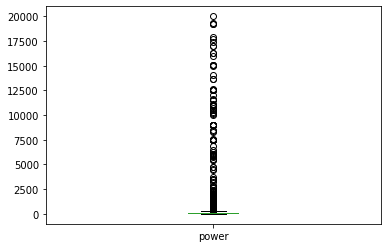

In [36]:
#Validamos valores atípicos para la característica 'power'.
cars_df['power'].plot(kind= 'box')

<AxesSubplot:>

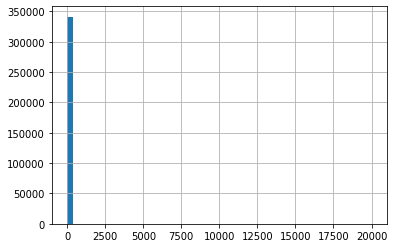

In [37]:
cars_df['power'].hist(bins=50)

In [38]:
# Verificamos cuentas observaciones mayores a 800 cv en la característica 'power' existen.
cars_df[cars_df['power'] > 800]['power'].shape[0]

305

In [39]:
print(f'porcentaje de menor a 800cv es: {round(cars_df[cars_df["power"] > 800]["power"].shape[0]/cars_df.shape[0]*100,2)} %')

porcentaje de menor a 800cv es: 0.09 %


**Conclusiones:**

La alta potencia es una característica de vehículos de alta gama. Ya que el dueño de un vehículo no optaría por una plataforma online para venderlo, filtraremos el conjunto datos con un límite de 800 cv en la característica 'power', esto eliminó el 0.09% de observaciones del conjunto de datos.

In [40]:
# Eliminamos los valores mayores a 800cv.
cars_df = cars_df[cars_df['power'] < 800]

**Validamos valores atípicos para la característica 'mileage'.**

<AxesSubplot:>

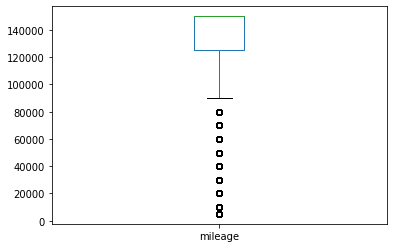

In [41]:
#Validamos valores atípicos para la característica 'mileage'.
cars_df['mileage'].plot(kind= 'box')

<AxesSubplot:>

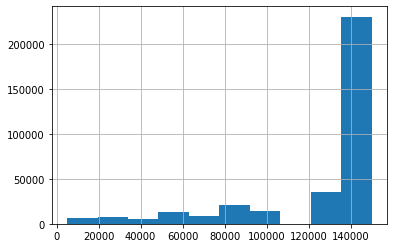

In [42]:
cars_df['mileage'].hist()

**Conclusiones:**

Para la característica 'mileage' no hemos encontrado ningún valor anómalo.

# Entrenamiento del modelo 

In [43]:
# Dividimos nuestro modelo en características y objetivo, en este caso el objetivo es 'price'.
X = cars_df.drop('price', axis= 1)
y = cars_df['price']

print('Tamaño características',X.shape)
print('Tamaño características',y.shape)

Tamaño características (341744, 9)
Tamaño características (341744,)


In [44]:
# Dividimos nuestro modelo en características y objetivo, en este caso el objetivo es 'price'.

X = cars_df.drop('price', axis= 1)
y = cars_df['price']

# Obtenemos OHE de X
X_ohe = pd.get_dummies(cars_df.drop('price', axis= 1))

print('Tamaño características',X.shape)
print('Tamaño objetivo',y.shape)
print('Tamaño caracteristicas OHE: ',X_ohe.shape)

Tamaño características (341744, 9)
Tamaño objetivo (341744,)
Tamaño caracteristicas OHE:  (341744, 316)


In [45]:
# Dividimos nuestros conjuntos de datos en entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

# Dividimos el conjunto OHE

X_ohe_train, X_ohe_test, y_ohe_train, y_ohe_test = train_test_split(X_ohe, y, test_size= 0.3, random_state= 42)

print('Tamaño X_train',X_train.shape)
print('Tamaño X_test',X_test.shape)
print('Tamaño y_train',y_train.shape)
print('Tamaño y_test',y_test.shape)
print('Tamaño X_ohe_train', X_ohe_train.shape)
print('Tamaño X_ohe_test', X_ohe_train.shape)

Tamaño X_train (239220, 9)
Tamaño X_test (102524, 9)
Tamaño y_train (239220,)
Tamaño y_test (102524,)
Tamaño X_ohe_train (239220, 316)
Tamaño X_ohe_test (239220, 316)


In [46]:
# Definimos una función para evaluar el modelo
def rmse_eval(predictions, y):
    return mean_squared_error(predictions, y) ** 0.5

In [47]:
# Definimos un diccionario donde se gurdarán las métricas de rendimiento.

metrics = {'fitting_time':[],
          'prediction_time':[],
          'RMSE': []}

## Regresión lineal

In [48]:
start = time.time()

rl_model = LinearRegression()
rl_model.fit(X_ohe_train, y_ohe_train)

finish_fit = time.time()

predictions = rl_model.predict(X_ohe_test)

finish_predict = time.time()

metrics['fitting_time'].append(round(finish_fit - start,3))
metrics['prediction_time'].append(round(finish_predict - finish_fit,3))
metrics['RMSE'].append(round(rmse_eval(predictions, y_ohe_test),3))

print('Tiempo de entrenamiento: ',metrics['fitting_time'][-1])
print('Tiempo de predicción: ',metrics['prediction_time'][-1])
print('RMSE: ',metrics['RMSE'][-1])

Tiempo de entrenamiento:  21.991
Tiempo de predicción:  0.234
RMSE:  2640.102


## Decission Tree Regresor

In [49]:
start = time.time()

params = {'max_depth':list(range(1,10)),'random_state': [42]}

dt_model = DecisionTreeRegressor()

#my_scorer = make_scorer(rmse_eval, greater_is_better=False)

grid = GridSearchCV(dt_model, params, scoring= 'neg_root_mean_squared_error', cv= 5)
grid.fit(X_ohe_train, y_ohe_train)

finish_fit = time.time()

predictions = grid.predict(X_ohe_test)

finish_predict = time.time()

metrics['fitting_time'].append(round(finish_fit - start,3))
metrics['prediction_time'].append(round(finish_predict - finish_fit,3))
metrics['RMSE'].append(round(rmse_eval(predictions, y_ohe_test),3))

print('Tiempo de entrenamiento: ',metrics['fitting_time'][-1])
print('Tiempo de predicción: ',metrics['prediction_time'][-1])
print('RMSE: ',metrics['RMSE'][-1])

Tiempo de entrenamiento:  143.526
Tiempo de predicción:  0.149
RMSE:  2074.846


## Random Forest Regressor

In [50]:
start = time.time()

params = {'max_depth':[2,4], 'n_estimators':[100,110], 'random_state': [42]}

rf_model = RandomForestRegressor()

grid = GridSearchCV(rf_model, params, scoring= 'neg_root_mean_squared_error', cv= 3)
grid.fit(X_ohe_train, y_ohe_train)

finish_fit = time.time()

predictions = grid.predict(X_ohe_test)

finish_predict = time.time()

metrics['fitting_time'].append(round(finish_fit - start,3))
metrics['prediction_time'].append(round(finish_predict - finish_fit,3))
metrics['RMSE'].append(round(rmse_eval(predictions, y_ohe_test),3))

print('Tiempo de entrenamiento: ',metrics['fitting_time'][-1])
print('Tiempo de predicción: ',metrics['prediction_time'][-1])
print('RMSE: ',metrics['RMSE'][-1])

Tiempo de entrenamiento:  1077.945
Tiempo de predicción:  0.537
RMSE:  2621.734


## XGB

In [51]:
start = time.time()

params = {
    'max_depth':[2,4], 
    'n_estimators':[100, 110], 
    'random_state': [42], 
    'eta': [0.1, 0.5]
}

XGB_model = XGBRegressor()
grid = GridSearchCV(XGB_model, params, scoring= 'neg_root_mean_squared_error', cv= 3)
grid.fit(X_ohe_train, y_ohe_train)

finish_fit = time.time()

predictions = grid.predict(X_ohe_test)

finish_predict = time.time()

metrics['fitting_time'].append(round(finish_fit - start,3))
metrics['prediction_time'].append(round(finish_predict - finish_fit,3))
metrics['RMSE'].append(round(rmse_eval(predictions, y_ohe_test),3))

print('Tiempo de entrenamiento: ',metrics['fitting_time'][-1])
print('Tiempo de predicción: ',metrics['prediction_time'][-1])
print('RMSE: ',metrics['RMSE'][-1])

Tiempo de entrenamiento:  4557.679
Tiempo de predicción:  1.369
RMSE:  1731.432


## CatBoost

In [52]:
# Identificamos los mejores hiperparámetros.
start = time.time()

categorical = ['vehicle_type','gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
best_rmse = 10000
best_iterations = None
best_learning_rate = None
best_depth = None

for iteration in [100,150]:
    for learning_r in [0.1,0.5,1]:
        for depth in [6,8]:
            cat_model = CatBoostRegressor(random_seed=42, silent=True, iterations= iteration, learning_rate= learning_r,
                                          depth= depth)
            cat_model.fit(X_train, y_train, cat_features= categorical)
            rmse = rmse_eval(cat_model.predict(X_test), y_test)
            if rmse < best_rmse:
                best_rmse = rmse
                best_iterations = iteration
                best_learning_rate = learning_r
                best_depth = depth

# Entrenamos el modelo con los mejores parámetros detectados y obtenemos los resultados de rendimiento.
                
cat_model = CatBoostRegressor(random_seed=42, silent=True, iterations= best_iterations, learning_rate= best_learning_rate,
                                          depth= best_depth)

cat_model.fit(X_train, y_train, cat_features= categorical)  

finish_fit = time.time()

predictions = cat_model.predict(X_test)

finish_predict = time.time()

metrics['fitting_time'].append(round(finish_fit - start,3))
metrics['prediction_time'].append(round(finish_predict - finish_fit,3))
metrics['RMSE'].append(round(rmse_eval(predictions, y_ohe_test),3))

print('Tiempo de entrenamiento: ',metrics['fitting_time'][-1])
print('Tiempo de predicción: ',metrics['prediction_time'][-1])
print('RMSE: ',metrics['RMSE'][-1])

Tiempo de entrenamiento:  416.27
Tiempo de predicción:  0.191
RMSE:  1638.482


## LightGBM

In [53]:
# Identificamos los mejores hiperparámetros.
start = time.time()

obj_feat = list(X_test.loc[:, X_test.dtypes == 'object'].columns.values)
for feature in obj_feat:
    X_train[feature] = pd.Series(X_train[feature], dtype="category")
    X_test[feature] = pd.Series(X_test[feature], dtype="category")

best_rmse = 10000
best_learningr = None
best_numleaves = None
best_maxb = None

for learning_r in [0.005, 0.01]:
    for numl in [120, 128]:
        for maxb in [512,560]:
            hyper_params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': None,
                'learning_rate': learning_r,
                "num_leaves": numl,  
                "max_bin": maxb
            }


            lgb_train = lgb.Dataset(X_train, y_train)
            gbm = lgb.train(hyper_params, lgb_train, num_boost_round=10, verbose_eval=False)

            predictions = gbm.predict(X_test)
            rmse = rmse_eval(gbm.predict(X_test), y_test)
            if rmse < best_rmse:
                
                best_eval = rmse
                best_learningr = learning_r
                best_numleaves = numl
                best_maxb = maxb

# Entrenamos el modelo con los mejores parámetros detectados y obtenemos los resultados de rendimiento.
hyper_params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': None,
                'learning_rate': best_learningr,
                "num_leaves": best_numleaves,  
                "max_bin": best_maxb
            }

lgb_train = lgb.Dataset(X_train, y_train)
gbm = lgb.train(hyper_params, lgb_train, num_boost_round=10, verbose_eval=False)   

finish_fit = time.time() 

predictions = gbm.predict(X_test)

finish_predict = time.time()

metrics['fitting_time'].append(round(finish_fit - start,3))
metrics['prediction_time'].append(round(finish_predict - finish_fit,3))
metrics['RMSE'].append(round(rmse_eval(predictions, y_ohe_test),3))

print('Tiempo de entrenamiento: ',metrics['fitting_time'][-1])
print('Tiempo de predicción: ',metrics['prediction_time'][-1])
print('RMSE: ',metrics['RMSE'][-1])

/tmp/ipykernel_44/2451273479.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[feature] = pd.Series(X_train[feature], dtype="category")
/tmp/ipykernel_44/2451273479.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[feature] = pd.Series(X_test[feature], dtype="category")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argume

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 239220, number of used features: 9
[LightGBM] [Info] Start training from score 4539.098148


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 239220, number of used features: 9
[LightGBM] [Info] Start training from score 4539.098148


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 239220, number of used features: 9
[LightGBM] [Info] Start training from score 4539.098148


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 239220, number of used features: 9
[LightGBM] [Info] Start training from score 4539.098148


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 239220, number of used features: 9
[LightGBM] [Info] Start training from score 4539.098148


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 239220, number of used features: 9
[LightGBM] [Info] Start training from score 4539.098148


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 239220, number of used features: 9
[LightGBM] [Info] Start training from score 4539.098148


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 239220, number of used features: 9
[LightGBM] [Info] Start training from score 4539.098148


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 239220, number of used features: 9
[LightGBM] [Info] Start training from score 4539.098148
Tiempo de entrenamiento:  331.672
Tiempo de predicción:  0.187
RMSE:  4180.448


# Análisis del modelo

In [54]:
index= ['linear Regresion','Decission Tree','Random Forest','XGB', 'Cat Boost', 'Light GBM']

In [55]:
metrics_df = pd.DataFrame(metrics, index= index)
metrics_df

,fitting_time,prediction_time,RMSE
linear Regresion,21.991,0.234,2640.102
Decission Tree,143.526,0.149,2074.846
Random Forest,1077.945,0.537,2621.734
XGB,4557.679,1.369,1731.432
Cat Boost,416.270,0.191,1638.482
Light GBM,331.672,0.187,4180.448


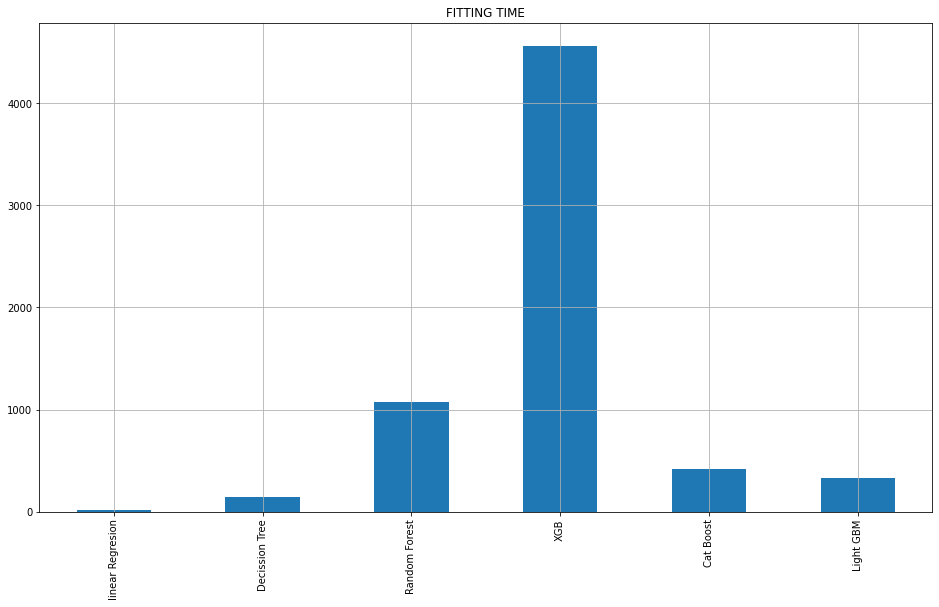

In [56]:
metrics_df['fitting_time'].plot(kind= 'bar', figsize= (16,9), grid= True, title= 'FITTING TIME')
plt.show()

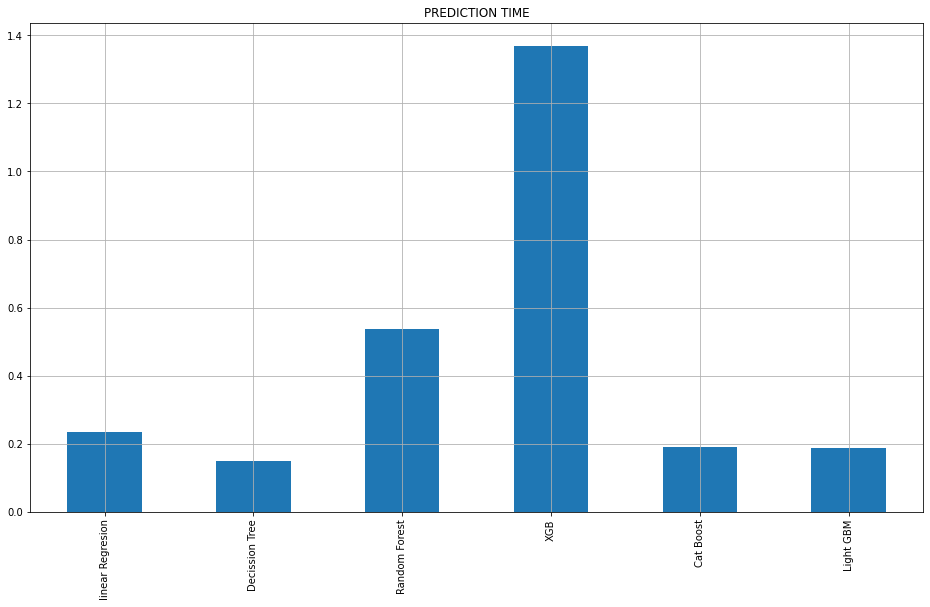

In [57]:
metrics_df['prediction_time'].plot(kind= 'bar', figsize= (16,9), grid= True, title= 'PREDICTION TIME')
plt.show()

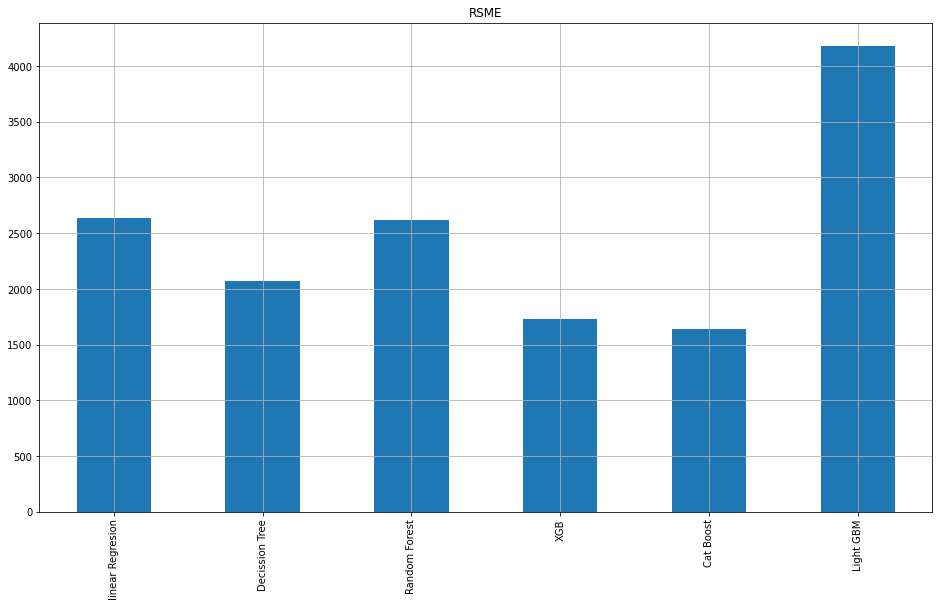

In [58]:
metrics_df['RMSE'].plot(kind= 'bar', figsize= (16,9), grid= True, title= 'RSME')
plt.show()

**CONCLLUSIONES:**

- El modelo XGB tiene un exelente valor RMSE, sin embargo el modelo que mas le toma tiempo aprender y predecir. No es una opción para el cliente por el tiempo de ejecución.

- El modelo LightGBM tiene unos exelentes tiempos de respuesta sin embargo el RMSE es muy alto, incluso su RMSE es mas elevado que el da la regresión lieneal, por lo que no pasa la prueba de cordura.

- El modelo Catboost sin embargo es sobresaliente en velocidad y métrica RMSE, este modelo sería el adecuado ya que cumple con un bajo tiempo de ejecución 